# Predicting Housing Prices in California

This notebook presents a framework for an end-to-end pipeline to implement ML on a basic data set of housing data with the objective to predict housing prices in California [1]. The data is stored on my personal github, which was copied from: 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'.

<b>Add more description here as the project progresses.</b>

---

[1]: A. Geron, 'Hands-on Machine Learning with Scikit-Learn, Keras & TensorFolow, Ch. 2.

### Setup


First setup a few modulues, set some defaults for matplotlib figures and setup a random seed so that the code runs the same each time.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tarfile
import urllib

# import scientific colourmap
import bilbao

# setup matplotlib default styles
print(mpl.get_configdir())
#plt.style.use('jvb_plt_style_1')

# Fixing random state for reproducibility
np.random.seed(42)

/home/jvanblitterswyk/.config/matplotlib


### Get the data
To start off, create a small function to automate fetching the data. This is useful for regularly fetching updates or when downloading the data on multiple machines is required.

In [2]:
## TO DO: download data set and have it on personal github
download_root = 'https://raw.githubusercontent.com/jaredvanblitterswyk/ml_handson_sklearn_keras_tf_v02/main/'
data_path = os.path.join('datasets','02_cali_housing') # path where data stored locally
data_url = download_root + 'datasets/02_cali_homes/housing.tgz' # full url to raw data on GitHub

def fetch_data(data_url = data_url, data_path = data_path):
    # make directory in current workspace
    os.makedirs(data_path, exist_ok=True)
    # define tar gz path to save locally
    tgz_path = os.path.join(data_path, 'housing.tgz')
    # download tar gz file
    urllib.request.urlretrieve(data_url, tgz_path)
    # open tar gz file and extract all as csv
    with tarfile.open(tgz_path) as file:
        file.extractall(path=data_path)

In [3]:
fetch_data()

### Load data

Create a small function to load in data into a dataframe

In [4]:
def load_data(data_path = data_path):
    csv_path = os.path.join(data_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [5]:
housing = load_data()

### Take a quick look at the data

Extract basic statistics and plot histogram of a few attributes in the data frame.

In [6]:
# print top five rows of dataframe
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
# get a quick description of the data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


From here we can see that only one attribute (total_bedrooms) contain missing values and all attributes are numeric except for 'ocean_proximity'. This attribute can be converted to numeric values for training an ML algorithm - to be addressed later. Lets take a look at what categories exist for the ocean_proximity attribute:

In [8]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Let's also take a look at the numeric attributes.

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


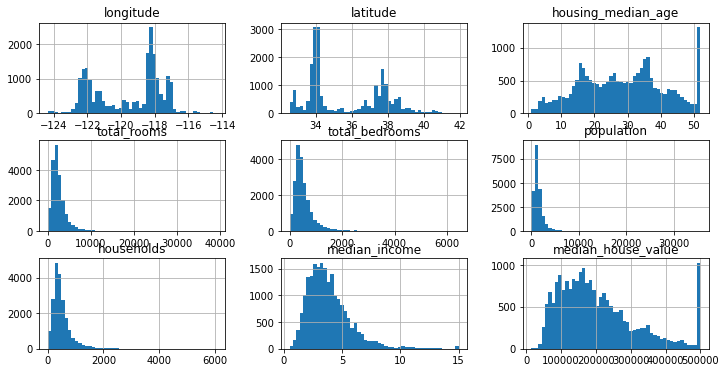

In [10]:
housing.hist(bins=50, figsize=(12,6))
plt.show()

From the above figures we can see several things:
1. Many of the attributes are tail heavy - this could lead to issues with training and normalization may be needed;
2. Median income appears to be capped at 15 (in ten thousands);
3. Median house value is also capped at 500,000. Since this is the value we want to predict, this could be quite consequential (discussed more below);
4. Housing median age is capped at 50;

The cap on median house value may prevent some ML algorithms from learning trends above this value and can be detrimental to performance. If predictive capability above this value is required, there are two ways to resolve this:

1. collect proper labels for the values that were capped, or;
2. remove capped districts from the training and test sets.



### Create a test set

How we go about separating a test set requires some careful consideration. Each time we run the training algorithm, we want to use the same set of data. Otherwise, over time the ML algorithm will eventually be trained on all available data creating bias/leakage.

A common solution is to use each instance's unique identifier (assuming there is one) to determine if an instance should be included in the training or test set. For example, you could compute a has of each instance's identifier and define a threshold on value to assign to training/test sets. Unfortunately, here we do not have a unique identifier so we must consider other options. One option is to use the index as an identifier but one must ensure that new data is always appended to the end of the data set. If this is not possible it is recommended to use the most stable identifier in the dataset (for example, here we could use longitude and latitude as these are guaranteed to be stable) but one must be careful that multiple points do not have the same identifier to avoid sampling bias.

Here we will use the scikit-learn built-in function train_test_split() to create a test set.

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42, shuffle = True)

Note that we set shuffle = True (default), which performs random sampling of the data. One must be aware that random sampling may not always be the most appropriate approach and can create skewed training and test sets. For example, in this data set, we may want to ensure that each income bracket is represented appropriately in the training and test sets. For this we need to use stratified sampling.

First, we will create 'cuts' in the data representing different categories for median income.

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

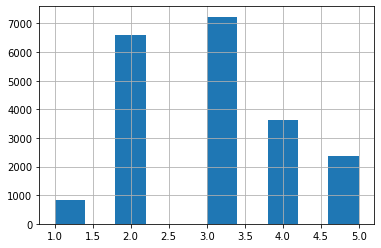

In [12]:
housing['income_cat'] = pd.cut(housing['median_income'], 
                               bins = [0., 1.5, 3., 4.5, 6., np.inf],
                              labels = [1, 2, 3, 4, 5])

housing['income_cat'].hist()

# display proportions of each income category
housing['income_cat'].value_counts()/len(housing)

Now we can do stratified random sampling on the data based on income category.

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# provide indices to split the data
split = StratifiedShuffleSplit(n_splits = 1, test_size= 0.2, random_state = 42)

# now loop through and assign to test and train sets

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
# check that it worked by comparing proportions of income categories in test set

strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

We can see that the stratified sampling of the full housing data set by income category produces very similar proportions of each category in the test set as in the 'population' (full set).

Finally, we will remove the income category so this is not used in training the data.

In [14]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis = 1, inplace = True)

In [16]:
strat_train_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

### Exploring the data